In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, ConfusionMatrixDisplay
# Ensure mean_absolute_error, mean_squared_error, and r2_score are imported
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


from google.colab import files


In [5]:
# Veri setini yükle
df = pd.read_excel("CWD.xlsx")

# Kullanılmayacak sütunları silelim
df = df.drop(columns=["Watershed_ID", "X centroid", "Y centrtoid","Recharge","Lithology_Class","Hydrogeological unit","Snow cover area (Km2)","Surface Runoff_avg (m3/s)","Number of faults","Equiped irrigated area (km2)"])

# Kontrol: Kategorik değişken var mı?
print(df.dtypes)

Watershed_Area (Km2)              float64
Karst area (Km2)                  float64
Watertable depth_avg (m)          float64
Precipitation_avg (mm/year)         int64
Eleveation_avg (m.a.s.l)            int64
Slope_avg (°)                     float64
Cropland area (Km2)               float64
Population density (people/km)    float64
Sea-level (m)                     float64
Springs within watershed           object
dtype: object


In [6]:
df["spring_count"] = df["Springs within watershed"].apply(
    lambda x: len(str(x).split(",")) if pd.notna(x) and str(x).strip() != "" else 0
)

In [7]:
def convert_recharge(value):
    if isinstance(value, str):
        if ">" in value:
            return 400
        elif "<" in value:
            return 50
        elif "-" in value:
            parts = value.split("-")
            return (float(parts[0]) + float(parts[1])) / 2
    return pd.to_numeric(value, errors="coerce")


In [8]:
df = df.drop(columns=["Springs within watershed"])


In [9]:
df.head()

,Watershed_Area (Km2),Karst area (Km2),Watertable depth_avg (m),Precipitation_avg (mm/year),Eleveation_avg (m.a.s.l),Slope_avg (°),Cropland area (Km2),Population density (people/km),Sea-level (m),spring_count
0,647.108052,0.000000,0.00,1053,46,3.1,0.000000,38.339,2.852533,6
1,369.462891,310.348828,1.97,1142,95,4.4,59.114062,19.850,3.922188,16
2,224.429338,0.000000,0.93,1119,73,3.4,20.198640,5.288,1.293898,0
3,421.217788,0.000000,3.44,1235,220,12.9,8.424356,5.230,1.293898,8
4,50.203521,0.000000,2.83,1000,53,4.5,5.522387,518.740,3.303307,5


In [10]:
# precipitation/slope oranı
df["precipitation_slope_ratio"] = df["Precipitation_avg (mm/year)"] / (df["Slope_avg (°)"] + 1e-5)

# Outlier temizliği (örneğin spring_count > 10 olanlar çıkarıldı)
df = df[df["spring_count"] <= 10]


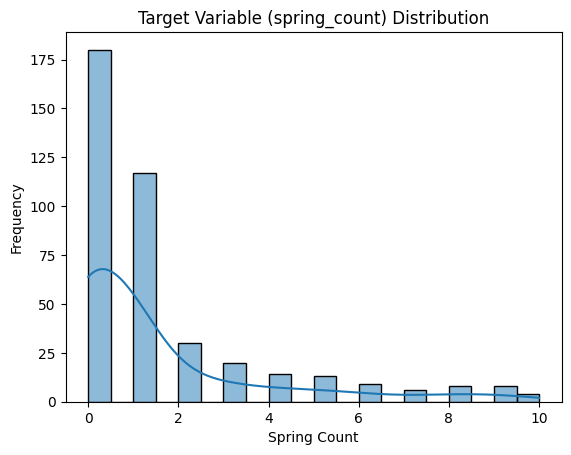

In [11]:
# Hedef değişkenin dağılımı
# Define the target variable y
y = df["spring_count"]
sns.histplot(y, bins=20, kde=True)
plt.title("Target Variable (spring_count) Distribution")
plt.xlabel("Spring Count")
plt.ylabel("Frequency")
plt.show()

In [12]:
# Log dönüşümü
y_log = np.log1p(y)

# Define features (X) by dropping the target variable from the dataframe
X = df.drop(columns=["spring_count"]) # Assuming 'spring_count' is your target variable

# Scaling
scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X) # You might want to scale X *after* the train-test split to avoid data leakage
# Let's adjust the scaling to happen after the split

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_log, test_size=0.3, random_state=42 # Use the unscaled X here
)

# Scale the training and testing feature sets separately to prevent data leakage
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Now X_train_scaled and X_test_scaled are ready for model training

In [13]:
from sklearn.tree import DecisionTreeRegressor
#Decision Tree
dt_model = DecisionTreeRegressor(max_depth=3, min_samples_split=10, min_samples_leaf=2, random_state=42)
dt_model.fit(X_train, y_train)
y_pred_dt = np.expm1(dt_model.predict(X_test))

mae_dt = mean_absolute_error(np.expm1(y_test), y_pred_dt)
mse_dt = mean_squared_error(np.expm1(y_test), y_pred_dt)
r2_dt = r2_score(np.expm1(y_test), y_pred_dt)


In [14]:
from sklearn.ensemble import RandomForestRegressor
#Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = np.expm1(rf_model.predict(X_test))

mae_rf = mean_absolute_error(np.expm1(y_test), y_pred_rf)
mse_rf = mean_squared_error(np.expm1(y_test), y_pred_rf)
r2_rf = r2_score(np.expm1(y_test), y_pred_rf)

In [15]:
#Gradient Boosting
from sklearn.ensemble import GradientBoostingRegressor

gb_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
gb_model.fit(X_train, y_train)
y_pred_gb = np.expm1(gb_model.predict(X_test))

mae_gb = mean_absolute_error(np.expm1(y_test), y_pred_gb)
mse_gb = mean_squared_error(np.expm1(y_test), y_pred_gb)
r2_gb = r2_score(np.expm1(y_test), y_pred_gb)


In [16]:
from sklearn.ensemble import ExtraTreesRegressor
#Extra Trees
et_model = ExtraTreesRegressor(n_estimators=100, random_state=42)
et_model.fit(X_train, y_train)
y_pred_et = np.expm1(et_model.predict(X_test))

mae_et = mean_absolute_error(np.expm1(y_test), y_pred_et)
mse_et = mean_squared_error(np.expm1(y_test), y_pred_et)
r2_et = r2_score(np.expm1(y_test), y_pred_et)


In [17]:
results = pd.DataFrame({
    'Model': ['DecisionTree', 'RandomForest', 'GradientBoosting', 'ExtraTrees'],
    'MAE': [mae_dt, mae_rf, mae_gb, mae_et],
    'MSE': [mse_dt, mse_rf, mse_gb, mse_et],
    'R2': [r2_dt, r2_rf, r2_gb, r2_et],
    'Accuracy (%)': [r2_dt * 100, r2_rf * 100, r2_gb * 100, r2_et * 100]


}).sort_values(by='R2', ascending=False)

print(results)


              Model       MAE       MSE        R2  Accuracy (%)
1      RandomForest  1.497289  5.214141  0.160461     16.046119
2  GradientBoosting  1.512577  5.383804  0.133143     13.314344
3        ExtraTrees  1.543360  5.685591  0.084552      8.455228
0      DecisionTree  1.538716  5.691217  0.083646      8.364634


In [18]:
import numpy as np

# Yeni özellikler ekle
df['log_watershed_area'] = np.log1p(df['Watershed_Area (Km2)'])
df['sqrt_cropland_area'] = np.sqrt(df['Cropland area (Km2)'])
df['pop_precip_interaction'] = df['Population density (people/km)'] * df['Precipitation_avg (mm/year)']


In [19]:
selected_features = [
    'Watershed_Area (Km2)',
    'log_watershed_area',
    'Karst area (Km2)',
    'sqrt_cropland_area',
    'Cropland area (Km2)',
    'Slope_avg (°)',
    'pop_precip_interaction',
    'Population density (people/km)'
]


In [20]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# X ve y
X = df[selected_features]
y = df['spring_count']

# Ölçekleme
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42
)

# Model
rf_model = RandomForestRegressor(
    n_estimators=200,
    max_depth=10,
    min_samples_split=5,
    random_state=42
)
rf_model.fit(X_train, y_train)

# Tahmin
y_pred = rf_model.predict(X_test)

# Performans metrikleri
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"RandomForest (Yeni Özelliklerle) Performance:")
print(f"MAE: {mae:.3f}")
print(f"MSE: {mse:.3f}")
print(f"R2: {r2:.3f}")


RandomForest (Yeni Özelliklerle) Performance:
MAE: 1.539
MSE: 4.855
R2: 0.218


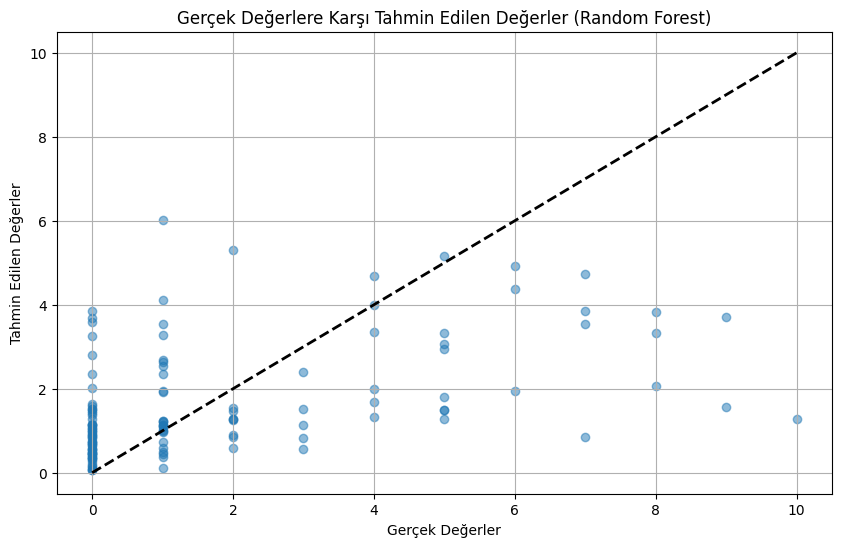

In [21]:
import matplotlib.pyplot as plt
# Tahmin edilen değerlere karşı gerçek değerler (Scatter plot)
plt.figure(figsize=(10, 6))
# Ensure y_test and y_pred are defined from previous cells before executing this one
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2) # İdeal çizgi
plt.xlabel("Gerçek Değerler")
plt.ylabel("Tahmin Edilen Değerler")
plt.title("Gerçek Değerlere Karşı Tahmin Edilen Değerler (Random Forest)")
plt.grid(True)
plt.show()

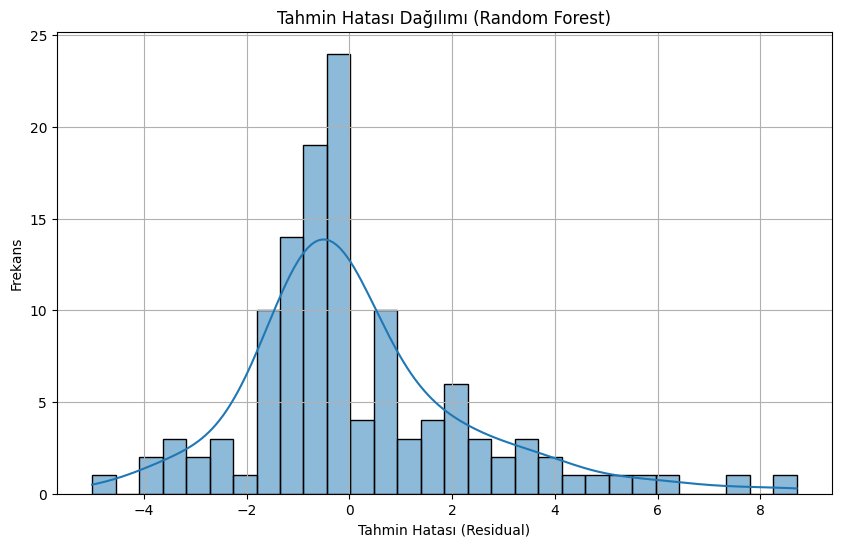

In [22]:
# Hata dağılımı (Residual plot)
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
sns.histplot(residuals, bins=30, kde=True)
plt.xlabel("Tahmin Hatası (Residual)")
plt.ylabel("Frekans")
plt.title("Tahmin Hatası Dağılımı (Random Forest)")
plt.grid(True)
plt.show()

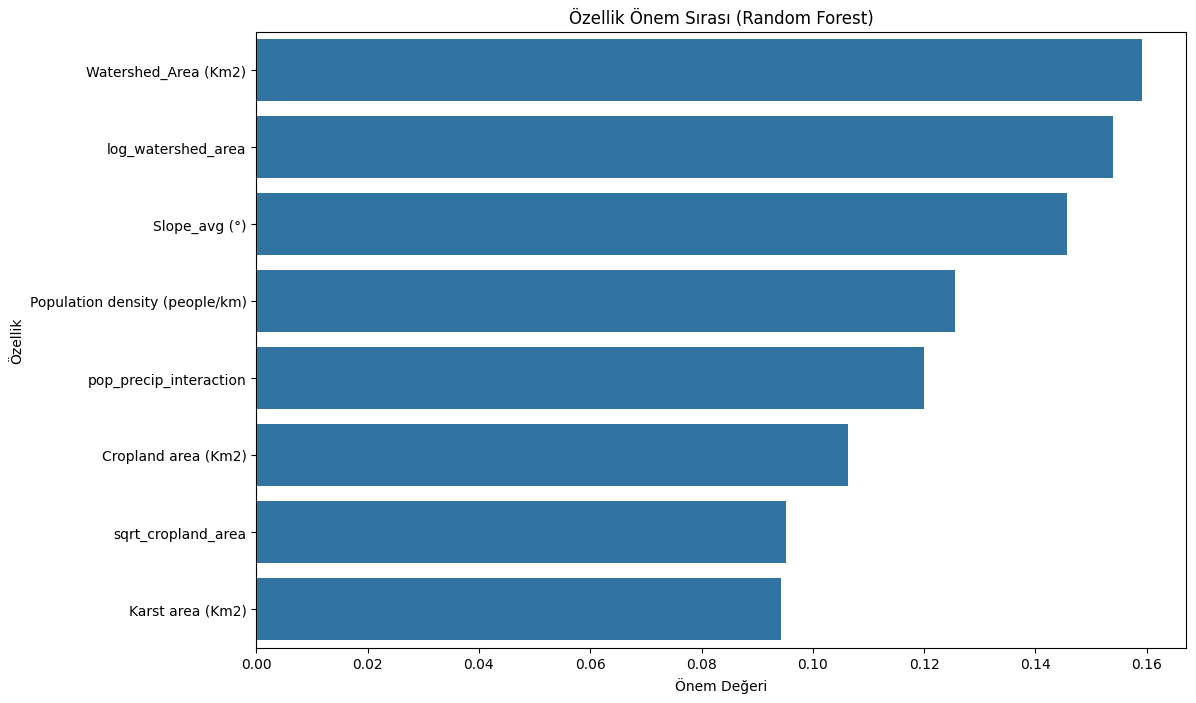

In [23]:
# Önemli özelliklerin gösterilmesi (Feature Importance)
feature_importances = rf_model.feature_importances_
features = X.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title("Özellik Önem Sırası (Random Forest)")
plt.xlabel("Önem Değeri")
plt.ylabel("Özellik")
plt.show()